# Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import statsmodels.api as sm
from sklearn.decomposition import PCA

# Defining functions

In [ ]:
# Function to replace NaN values in a column based on the distribution for specified countries

np.random.seed(101)

def replace_na_by_countries(df, column, countries):
    # Iterate over each country in the specified list and replace NaN values based on the distribution
    for country in countries:
        # Create a mask for the current country
        country_mask = df['country'] == country

        # Get non-null values in the current column for the current country
        non_null_values = df.loc[country_mask, column].dropna()

        # Calculate probability distribution for the non-null values
        prob_distribution = non_null_values.value_counts(normalize=True)

        # Check if the probability distribution is not empty
        if not prob_distribution.empty:
            # Replace NaN values in the current column for the current country
            missing_values_mask = country_mask & df[column].isna()
            df.loc[missing_values_mask, column] = np.random.choice(prob_distribution.index,
                                                                   size=missing_values_mask.sum(),
                                                                   p=prob_distribution)

# Function to map values in 'prr_vote' column

def map_party_id(value):
    if value in party_id_set:
        return 1
    else:
        return 0

# Function to change from numerical values in the V241 (Year of birth) column to strings

def generation(value):
    try:
        year = float(value)
        if year <= 1945:
            return 'prewar'
        elif 1946 <= year <= 1964:
            return 'boomer'
        elif 1965 <= year <= 1980:
            return 'generation_x'
        else:
            return 'millennial'
    except ValueError:
        return 'invalid'

# Function for linear transformation

def linear_transformation(original_values, transformed_min, transformed_max):
    slope = (transformed_max - transformed_min) / (max(original_values) - min(original_values))
    intercept = transformed_min - slope * min(original_values)
    transformed_values = (slope * original_values) + intercept
    return transformed_values

# Function to map number of children

def map_children(x):
    if x == 0:
        return 'no children'
    else:
        return 'children'

'''# Cox-Snell

def cox_snell_r_squared(log_likelihood, n, base_rate):
    return 1 - np.exp(-2 * log_likelihood / n) ** (2 / n)

# Nagelkerke's R-squared

def nagelkerke_r_squared(cox_snell_r_squared, max_possible_r_squared):
    return cox_snell_r_squared / max_possible_r_squared
'''

"# Cox-Snell\n\ndef cox_snell_r_squared(log_likelihood, n, base_rate):\n    return 1 - np.exp(-2 * log_likelihood / n) ** (2 / n)\n\n# Nagelkerke's R-squared\n\ndef nagelkerke_r_squared(cox_snell_r_squared, max_possible_r_squared):\n    return cox_snell_r_squared / max_possible_r_squared\n"

# Importing the data

In [ ]:
# Importing data from the World Values Survery Wave 6

wvs6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/WVS_6.csv')

<ipython-input-103-1263d5bdaa39>:3: DtypeWarning: Columns (411,416,421,431,436,441) have mixed types. Specify dtype option on import or set low_memory=False.
  wvs6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/WVS_6.csv')


# Data cleaning and preprocessing

In [ ]:
# Parsing countries from COW column to actual names

country_mapping_wvs6 = {
    2: 'United States of America',41: 'Haiti',52: 'Trinidad and Tobago',
    70: 'Mexico',100: 'Colombia',130: 'Ecuador',135: 'Peru',140: 'Brazil',
    155: 'Chile',160: 'Argentina',165: 'Uruguay',210: 'Netherlands',
    230: 'Spain',255: 'Germany',290: 'Poland',349: 'Slovenia',352: 'Cyprus',
    360: 'Romania',365: 'Russia',366: 'Estonia',369: 'Ukraine',370: 'Belarus',
    371: 'Armenia',372: 'Georgia',373: 'Azerbaijan',380: 'Sweden',452: 'Ghana',
    475: 'Nigeria',517: 'Rwanda',552: 'Zimbabwe',560: 'South Africa',
    600: 'Morocco',615: 'Algeria',616: 'Tunisia',620: 'Libya',640: 'Turkey',
    645: 'Iraq',651: 'Egypt',660: 'Lebanon',663: 'Jordan',667: 'Palestine',
    679: 'Yemen',690: 'Kuwait',692: 'Bahrain',694: 'Qatar',703: 'Kyrgyzstan',
    704: 'Uzbekistan',705: 'Kazakhstan',710: 'China',713: 'Taiwan',
    714: 'Hong Kong',732: 'South Korea',740: 'Japan',750: 'India',
    770: 'Pakistan',800: 'Thailand',820: 'Malasia',830: 'Singapore',
    840: 'Philippines',900: 'Australia',920: 'New Zealand'
}

In [ ]:
# Mapping the country codes to country names from COW column

wvs6['COW'] = wvs6['COW'].map(country_mapping_wvs6)

In [ ]:
# Selecting data only from countries where there is information about the PRR universe

prr_countries_wvs6 = ['Sweden', 'Netherlands', 'Cyprus', 'New Zealand',
                      'Armenia','Estonia', 'Poland', 'Russia', 'Ukraine']

In [ ]:
# Creating a temporary variable to store data

_wvs6 = wvs6.loc[wvs6['COW'].isin(prr_countries_wvs6)]

In [ ]:
# Selecting questions

# Country:
_country = ['COW']

# Authoritarianism scale:
_authoritarianism = ['V21', 'V66', 'V69', 'V127', 'V128', 'V135',
                     'V138', 'V187']
                    # Removed 'V36', 'V129'
                    # Added 'V21'

# Nativism scale:
_nativism = ['V37', 'V39', 'V41', 'V44', 'V46', 'V106', 'V107',
                    'V154', 'V156', 'V212']

# Equality scale:
#_equality = ['V96', 'V131']

# Genre scale:
_genre = ['V40', 'V45', 'V47', 'V48', 'V50', 'V51', 'V52', 'V53',
          'V54', 'V139']

# Populism scale:
_populism = ['V98', 'V109', 'V110','V113', 'V114', 'V115', 'V116',
                    'V117', 'V119', 'V120','V121', 'V126']

# Demographic data:
_demo = ['V57', 'V58', 'V59', 'V147', 'V188', 'V229', 'V239', 'V240',
         'V241', 'V248', 'V253', 'V265']

_positioning = ['V95', 'V191']

# Indepemdemt variable:

vote = ['V228']

In [ ]:
# Combine all scales into a list and then create a new DataFrame
all_scales = [_country, _authoritarianism, _nativism, _genre, _populism, _demo,
              _positioning, vote]

# Create an empty DataFrame to store the selected columns from each scale
combined_df = pd.DataFrame()

# Iterate through each scale and select the corresponding columns
for scale in all_scales:
    combined_df = pd.concat([combined_df, _wvs6[scale]], axis=1)

In [ ]:
# Renaming COW column to country and V228 to prr_vote

combined_df.rename(columns={'COW': 'country'}, inplace=True)
combined_df.rename(columns={'V228': 'prr_vote'}, inplace=True)

In [ ]:
# Removing non respondents to V241 and setting NaN values for prr_vote

combined_df = combined_df[~combined_df['prr_vote'].isin([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7])]
combined_df = combined_df[~combined_df['V241'].isin([-1, -2])]

In [ ]:
# Creating a new dataframe without non-respondents to V241

filtered_df = pd.DataFrame(data=combined_df, columns=combined_df.columns)

# Reseting the index of the DataFrame
filtered_df.reset_index(drop=True, inplace=True)

In [ ]:
# Replacing negative values (missing values) with NaN

filtered_df.replace(to_replace=[-5,-4,-3,-2,-1], value=np.nan, inplace=True)

In [ ]:
# Step 1: Filter the DataFrame to exclude rows from New Zealand and exclude NaN values from specified columns
selected_data = filtered_df[(filtered_df['country'] != 'New Zealand') &
                            (~filtered_df['V106'].isna()) &
                            (~filtered_df['V107'].isna()) &
                            (~filtered_df['V212'].isna())]

# Step 2: Calculate mode values for columns 'V106', 'V107', and 'V212' from filtered data
mode_values = selected_data[['V106', 'V107', 'V212']].mode()

# Step 3: Fill NaN values in these columns for New Zealand with mode values
filtered_df.loc[filtered_df['country'] == 'New Zealand', ['V106', 'V107', 'V212']] = \
    filtered_df.loc[filtered_df['country'] == 'New Zealand', ['V106', 'V107', 'V212']].fillna(mode_values.iloc[0])

In [ ]:
# Iterate over each column and replace NaN values based on the distribution for specified countries.

for column in filtered_df.columns:
    replace_na_by_countries(filtered_df, column, prr_countries_wvs6)

In [ ]:
# Parsing binary values to 0/1 scale

filtered_df['V21'] = filtered_df['V21'].replace({2: 0})
filtered_df['V37'] = filtered_df['V37'].replace({2: 0})
filtered_df['V39'] = filtered_df['V39'].replace({2: 0})
filtered_df['V40'] = filtered_df['V40'].replace({2: 0})
filtered_df['V41'] = filtered_df['V41'].replace({2: 0})
filtered_df['V44'] = filtered_df['V44'].replace({2: 0})
filtered_df['V66'] = filtered_df['V66'].replace({2: 0})

In [ ]:
min_max_values_6 = {
    'V21': {'min': filtered_df['V21'].min(), 'max': filtered_df['V21'].max()},
    'V37': {'min': filtered_df['V37'].min(), 'max': filtered_df['V37'].max()},
    'V39': {'min': filtered_df['V39'].min(), 'max': filtered_df['V39'].max()},
    'V40': {'min': filtered_df['V40'].min(), 'max': filtered_df['V40'].max()},
    'V41': {'min': filtered_df['V41'].min(), 'max': filtered_df['V41'].max()},
    'V44': {'min': filtered_df['V44'].min(), 'max': filtered_df['V44'].max()},
    'V45': {'min': filtered_df['V45'].min(), 'max': filtered_df['V45'].max()},
    'V46': {'min': filtered_df['V46'].min(), 'max': filtered_df['V46'].max()},
    'V47': {'min': filtered_df['V47'].min(), 'max': filtered_df['V47'].max()},
    'V50': {'min': filtered_df['V50'].min(), 'max': filtered_df['V50'].max()},
    'V51': {'min': filtered_df['V51'].min(), 'max': filtered_df['V51'].max()},
    'V52': {'min': filtered_df['V52'].min(), 'max': filtered_df['V52'].max()},
    'V53': {'min': filtered_df['V53'].min(), 'max': filtered_df['V53'].max()},
    'V54': {'min': filtered_df['V54'].min(), 'max': filtered_df['V54'].max()},
    'V66': {'min': filtered_df['V66'].min(), 'max': filtered_df['V66'].max()},
    'V69': {'min': filtered_df['V69'].min(), 'max': filtered_df['V69'].max()},
    'V98': {'min': filtered_df['V98'].min(), 'max': filtered_df['V98'].max()},
    'V106': {'min': filtered_df['V106'].min(), 'max': filtered_df['V106'].max()},
    'V107': {'min': filtered_df['V107'].min(), 'max': filtered_df['V107'].max()},
    'V109': {'min': filtered_df['V109'].min(), 'max': filtered_df['V109'].max()},
    'V110': {'min': filtered_df['V110'].min(), 'max': filtered_df['V110'].max()},
    'V113': {'min': filtered_df['V113'].min(), 'max': filtered_df['V113'].max()},
    'V114': {'min': filtered_df['V114'].min(), 'max': filtered_df['V114'].max()},
    'V115': {'min': filtered_df['V115'].min(), 'max': filtered_df['V115'].max()},
    'V116': {'min': filtered_df['V116'].min(), 'max': filtered_df['V116'].max()},
    'V117': {'min': filtered_df['V117'].min(), 'max': filtered_df['V117'].max()},
    'V119': {'min': filtered_df['V119'].min(), 'max': filtered_df['V119'].max()},
    'V120': {'min': filtered_df['V120'].min(), 'max': filtered_df['V120'].max()},
    'V121': {'min': filtered_df['V121'].min(), 'max': filtered_df['V121'].max()},
    'V126': {'min': filtered_df['V126'].min(), 'max': filtered_df['V126'].max()},
    'V127': {'min': filtered_df['V127'].min(), 'max': filtered_df['V127'].max()},
    'V128': {'min': filtered_df['V128'].min(), 'max': filtered_df['V128'].max()},
    'V135': {'min': filtered_df['V135'].min(), 'max': filtered_df['V135'].max()},
    'V138': {'min': filtered_df['V138'].min(), 'max': filtered_df['V138'].max()},
    'V139': {'min': filtered_df['V139'].min(), 'max': filtered_df['V139'].max()},
    'V154': {'min': filtered_df['V154'].min(), 'max': filtered_df['V154'].max()},
    'V191': {'min': filtered_df['V191'].min(), 'max': filtered_df['V191'].max()}

}
# Apply linear transformation to each variable and create individual transformed columns
for scale, values in min_max_values_6.items():
    transformed_values = linear_transformation(filtered_df[scale], 0, 10)  # Transform to 1-10 scale
    filtered_df[f'{scale}_t'] = transformed_values  # Create individual transformed column

In [ ]:
# Selecting transformed questions

# Country:
country = ['country']

# Authoritarianism scale:
t_authoritarianism = ['V21_t', 'V66_t', 'V69_t', 'V127_t', 'V128_t', 'V135_t',
                        'V138_t']
                    # Removed 'V36', 'V129'
                    # Added 'V21'

# Nativism scale:
t_nativism = ['V37_t', 'V39_t', 'V41_t', 'V44_t', 'V46_t', 'V106_t', 'V107_t',
                'V154_t']

# Equality scale:
#_equality = ['V96', 'V131']

# Genre scale:
t_genre = ['V40_t', 'V45_t', 'V47_t', 'V50_t', 'V51_t', 'V52_t',
             'V53_t', 'V54_t', 'V139_t']

# Populism scale:
t_populism = ['V98_t', 'V109_t', 'V110_t','V113_t', 'V114_t', 'V115_t',
                'V116_t', 'V117_t', 'V119_t', 'V120_t','V121_t', 'V126_t']

# Demographic data:
t_demo = ['V57', 'V58', 'V59', 'V147', 'V188', 'V229', 'V239', 'V240',
          'V241', 'V248', 'V253', 'V265']

t_positioning = ['V95', 'V191_t']

# Indepemdemt variable:

vote = ['prr_vote']

In [ ]:
# Combine all scales into a list and then create a new DataFrame
all_scales = [country, t_authoritarianism, t_nativism, t_genre, t_populism,
              t_positioning, t_demo, vote]

# Create an empty DataFrame to store the selected columns from each scale
transformed_df = pd.DataFrame()

# Iterate through each scale and select the corresponding columns
for scale in all_scales:
    transformed_df = pd.concat([transformed_df, filtered_df[scale]], axis=1)

# Mapping the dependet variable column

In [ ]:
# Parsing countries from prr_vote column to actual vote for the prr from the populist_radical_right_ranking.ipynb

party_id_list = [752009, 528013, 528006, 196018, 196003, 554008, 51027, 233029,
                 616031, 643003, 804102, 804101, 804113, 804102]

# Create a set for faster lookup
party_id_set = set(party_id_list)

# Apply the function to the 'prr_vote' column
transformed_df['prr_vote'] = transformed_df['prr_vote'].map(map_party_id)

In [ ]:
transformed_df['prr_vote'].value_counts()

0    7418
1    1044
Name: prr_vote, dtype: int64

In [ ]:
# Measuring the correlation between self-positioning in the political scale and vote for the populist radical right

correlation_value = transformed_df['V95'].corr(transformed_df['prr_vote'])

print('Correlation between Self Positioning in Political Scale and Populist Radical Right Vote:', round(correlation_value*100,2),'%')

Correlation between Self Positioning in Political Scale and Populist Radical Right Vote: 8.01 %


In [ ]:
transformed_df['V241'].value_counts()

1958    175
1946    172
1959    169
1961    166
1954    163
       ... 
1923      5
1994      4
1921      3
1919      2
1920      1
Name: V241, Length: 76, dtype: int64

# Demographic variables adjustments

In [ ]:
# Parsing marital status from V57 column to actual names

marital_status = {1: 'married', 2: 'married', 3: 'separated_divorced_widowed',
                    4: 'separated_divorced_widowed',
                    5: 'separated_divorced_widowed', 6: 'never married'
}

# Mapping marital status numeric values to marital status married or not married  from V57 column

transformed_df['V57'] = transformed_df['V57'].map(marital_status)

# Dropping the never married dummy variable.
category_to_drop_1 = 'never married'

# Create dummy variables without dropping the first category
dummy_df_1 = pd.get_dummies(transformed_df['V57'], prefix='V57', drop_first=False)

# Drop the specified category
if f'V57_{category_to_drop_1}' in dummy_df_1.columns:
    dummy_df_1.drop(f'V57_{category_to_drop_1}', axis=1, inplace=True)



In [ ]:
# Parsing how many children from V58 column to actual names

children = {0: 'no children', 1: 'children', 2: 'children', 3: 'children',
              4: 'children', 5: 'children', 6: 'children', 7: 'children',
              8: 'children'
}

# Mapping children numeric values to marital status married or not married  from V57 column

transformed_df['V58'] = transformed_df['V58'].map(children)

# Dropping the children dummy variable.
category_to_drop_2 = 'no children'

# Create dummy variables without dropping the first category
dummy_df_2 = pd.get_dummies(transformed_df['V58'], prefix='V58', drop_first=False)

# Drop the specified category
if f'V58_{category_to_drop_2}' in dummy_df_2.columns:
    dummy_df_2.drop(f'V58_{category_to_drop_2}', axis=1, inplace=True)

In [ ]:
# Parsing religious status from V147 column to actual names

religious = {
    1:'religious', 2:'no religious', 3:'no religious'
}

# Mapping the religious status numeric values to religious status names from V147 column

transformed_df['V147'] = transformed_df['V147'].map(religious)

dummy_df_3 = pd.get_dummies(transformed_df['V147'], drop_first=True)

In [ ]:
# Parsing employment status from V229 column to actual names

employment_type = {
    1: 'employed', 2: 'employed', 3: 'employed', 4: 'employed',
    5: 'unemployed', 6: 'unemployed', 7: 'unemployed', 8: 'unemployed'
}

# Mapping the employment status numeric values to employment status names from V229 column

transformed_df['V229'] = transformed_df['V229'].map(employment_type)

dummy_df_4 = pd.get_dummies(transformed_df['V229'], drop_first=True)

In [ ]:
 # Parsing scale of incomes from V239 column to actual names

incomes_scale = {
    1: 'first_halve',2: 'first_halve',3: 'first_halve',4: 'first_halve',
    5: 'first_halve',6: 'second_halve',7: 'second_halve',8: 'second_halve',
    9: 'second_halve', 10: 'second_halve'
}

# Mapping the scale of incomes numeric values to scale of incomes names from V239 column

transformed_df['V239'] = transformed_df['V239'].map(incomes_scale)

dummy_df_5 = pd.get_dummies(transformed_df['V239'], drop_first=True)

In [ ]:
# Parsing sex from V240 column to actual names

sex = {
    1: 'male',2: 'female'
}

# Mapping sex numeric values to sex names from V240 column

transformed_df['V240'] = transformed_df['V240'].map(sex)

dummy_df_6 = pd.get_dummies(transformed_df['V240'], drop_first=True)

In [ ]:
# Replacing numerical values in the V241 (Year of birth) column to strings

transformed_df['V241'] = transformed_df['V241'].apply(generation)

# Dropping the prewar dummy variable.
category_to_drop_3 = 'prewar'

# Create dummy variables without dropping the first category
dummy_df_7 = pd.get_dummies(transformed_df['V241'], prefix='V241', drop_first=False)

# Drop the specified category
if f'V241_{category_to_drop_3}' in dummy_df_7.columns:
    dummy_df_7.drop(f'V241_{category_to_drop_3}', axis=1, inplace=True)

In [ ]:
# Parsing educational level numeric values from V248 column to actual names

educational_level = {
    1: 'no_university_education',2: 'no_university_education',
    3: 'no_university_education',4: 'no_university_education',
    5: 'no_university_education',6: 'no_university_education',
    7: 'no_university_education',8: 'university_education',
    9: 'university_education'
}

# Mapping educational level numeric values to educational level names from V248 column

transformed_df['V248'] = transformed_df['V248'].map(educational_level)

dummy_df_8 = pd.get_dummies(transformed_df['V248'], drop_first=True)

In [ ]:
# Parsing size of town numeric values from V253 column to actual names

town_size = {
    1:'rural', 2:'rural', 3:'rural',
    4:'rural', 5:'urban', 6:'urban',
    7:'urban', 8:'urban'
}

# Mapping size of town numeric values to size of town names from V253 column

transformed_df['V253'] = transformed_df['V253'].map(town_size)

dummy_df_9 = pd.get_dummies(transformed_df['V253'], drop_first=True)

In [ ]:
# Replacing numerical values in the V241 (Year of birth) column to strings

occupation = {
    1:'manager', 2:'manager', 3:'routine_non_manual',
    4:'routine_non_manual', 5:'routine_non_manual', 6:'manager',
    7:'skilled_manual', 8:'manual', 9:'manual', 10:'petty_bourgeoisie',
    11:'manual', 12:'routine_non_manual', 13: 'manual'
}

# Mapping size of town numeric values to size of town names from V253 column

transformed_df['V265'] = transformed_df['V265'].map(occupation)

# Dropping the prewar dummy variable.
category_to_drop_4 = 'manual'

# Create dummy variables without dropping the first category
dummy_df_10 = pd.get_dummies(transformed_df['V265'], prefix='V265', drop_first=False)

# Drop the specified category
if f'V265_{category_to_drop_4}' in dummy_df_10.columns:
    dummy_df_10.drop(f'V265_{category_to_drop_4}', axis=1, inplace=True)

In [ ]:
# List of demographic dummy variables DataFrames
demo_df = [dummy_df_1, dummy_df_2, dummy_df_3, dummy_df_4, dummy_df_5,
           dummy_df_6, dummy_df_7, dummy_df_8, dummy_df_9, dummy_df_10]

# Concatenate all dummy DataFrames along the columns (axis=1)
merged_demo_df = pd.concat(demo_df, axis=1)

# Concatenate the merged dummy DataFrame with the original DataFrame
combined_df_demo = pd.concat([transformed_df, merged_demo_df], axis=1)

# First trial: Standarizing values from each question (except demographic scales) + performing the Logist Regression. Acurracy = 25%


In [ ]:
# Create a new DataFrame without the _demo columns
new_df_without_demo = transformed_df.drop(_demo, axis=1)

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(new_df_without_demo.drop(['country','prr_vote'],axis=1))

StandardScaler()

In [ ]:
scaled_features = scaler.transform(new_df_without_demo.drop(['country','prr_vote'],axis=1))

In [ ]:
df_feat = pd.DataFrame(scaled_features,columns=new_df_without_demo.columns[1:-1])
df_feat.reset_index(drop=True)

,V21_t,V66_t,V69_t,V127_t,V128_t,V135_t,V138_t,V37_t,V39_t,V41_t,...,V114_t,V115_t,V116_t,V117_t,V119_t,V120_t,V121_t,V126_t,V95,V191_t
0,1.409588,0.702662,-0.829699,0.318144,0.643629,1.505534,1.280520,2.318791,-0.537729,2.366564,...,1.772103,-0.732668,0.121871,0.343209,1.221615,0.549702,1.688065,-0.595634,1.498367,0.814611
1,1.409588,0.702662,-0.829699,0.318144,-0.490327,1.155846,0.595233,-0.431259,-0.537729,-0.422554,...,-0.526768,-0.732668,-1.205373,-0.898978,-0.145573,-0.798191,-0.670265,-0.595634,-0.237378,-1.984106
2,1.409588,-1.423160,-0.829699,-0.643675,0.643629,-0.592593,0.595233,2.318791,-0.537729,2.366564,...,0.622667,1.661091,0.121871,0.343209,2.588803,0.549702,0.508900,1.803344,1.064431,-0.118294
3,1.409588,0.702662,-0.829699,0.318144,-0.490327,-0.242905,0.595233,-0.431259,1.859671,-0.422554,...,0.622667,-0.732668,0.121871,-0.898978,2.588803,0.549702,-0.670265,-0.595634,1.064431,-1.051200
4,1.409588,0.702662,-0.829699,0.318144,-0.490327,0.456470,1.623164,2.318791,-0.537729,2.366564,...,-0.526768,-1.929547,-2.532617,-0.898978,-0.145573,0.549702,0.508900,-0.595634,1.932303,-1.051200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8457,1.409588,-1.423160,-0.829699,-0.643675,0.643629,-0.242905,-1.117985,-0.431259,-0.537729,-0.422554,...,0.622667,0.464212,0.121871,0.343209,1.221615,0.549702,0.508900,0.603855,0.630495,-1.984106
8458,1.409588,-1.423160,0.601097,-1.605494,0.643629,-0.592593,-0.432698,-0.431259,1.859671,-0.422554,...,1.772103,1.661091,1.449114,1.585395,2.588803,1.897595,1.688065,1.803344,0.196558,-1.984106
8459,1.409588,-1.423160,0.601097,-1.605494,-0.490327,1.155846,0.937877,2.318791,1.859671,2.366564,...,-0.526768,-0.732668,0.121871,0.343209,-0.145573,-0.798191,-0.670265,-1.795122,-0.237378,-1.984106
8460,-0.709427,0.702662,0.601097,-1.605494,-1.624282,-0.242905,0.252589,-0.431259,-0.537729,-0.422554,...,-1.676203,-1.929547,-2.532617,-0.898978,-0.145573,-0.798191,-0.670265,-1.795122,-0.237378,-1.984106


In [ ]:
'''
# List of columns with reverse-coded responses
reverse_coded_columns = ['V95', 'V128_t', 'V135_t', 'V138_t','V106_t','V107_t','V212_t','V48_t', 'V98_t', 'V109_t', 'V110_t','V113_t', 'V114_t', 'V115_t', 'V116_t','V117_t', 'V119_t', 'V120_t','V121_t', 'V126_t']

# Invert the sign of values in reverse-coded columns
df_feat[reverse_coded_columns] *= -1
'''

"\n# List of columns with reverse-coded responses\nreverse_coded_columns = ['V95', 'V128_t', 'V135_t', 'V138_t','V106_t','V107_t','V212_t','V48_t', 'V98_t', 'V109_t', 'V110_t','V113_t', 'V114_t', 'V115_t', 'V116_t','V117_t', 'V119_t', 'V120_t','V121_t', 'V126_t']\n\n# Invert the sign of values in reverse-coded columns\ndf_feat[reverse_coded_columns] *= -1\n"

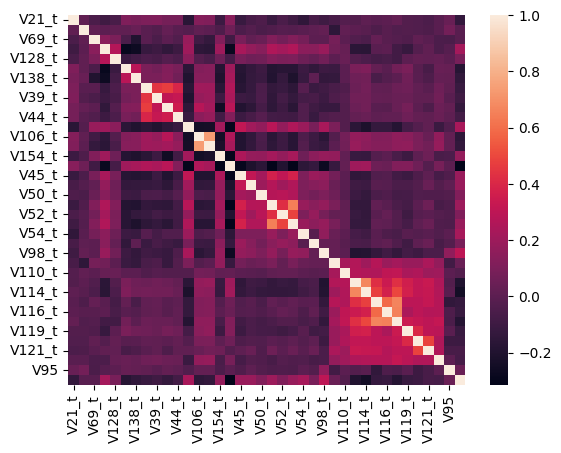

In [ ]:
sns.heatmap(df_feat.corr())
plt.show()

In [ ]:
X_1 = df_feat
y_1 = new_df_without_demo['prr_vote']

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.25, random_state=101, stratify=y_1)

In [ ]:
undersampler_1 = RandomUnderSampler(random_state=101)
X_train_resampled_1, y_train_resampled_1 = undersampler_1.fit_resample(X_train_1, y_train_1)

In [ ]:
logmodel_1 = LogisticRegression()

In [ ]:
logmodel_1.fit(X_train_resampled_1,y_train_resampled_1)

LogisticRegression()

In [ ]:
y_pred_1 = logmodel_1.predict(X_test_1)

In [ ]:
print(classification_report(y_test_1,y_pred_1))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79      1855
           1       0.23      0.68      0.34       261

    accuracy                           0.68      2116
   macro avg       0.58      0.68      0.56      2116
weighted avg       0.85      0.68      0.73      2116



In [ ]:
print(confusion_matrix(y_test_1,y_pred_1))

[[1257  598]
 [  84  177]]


In [ ]:
coefficients_1 = logmodel_1.coef_
coef_df_1 = pd.DataFrame(coefficients_1, columns=df_feat.columns)
coef_df_1

,V21_t,V66_t,V69_t,V127_t,V128_t,V135_t,V138_t,V37_t,V39_t,V41_t,...,V114_t,V115_t,V116_t,V117_t,V119_t,V120_t,V121_t,V126_t,V95,V191_t
0,-0.043778,0.055359,-0.153378,-0.174193,-0.066413,0.044681,0.043238,0.063198,0.008634,0.210348,...,0.084718,0.512514,-0.250476,0.187633,0.083339,-0.117513,-0.131313,-0.032349,0.324904,-0.063922


# Second trial: Standarizing values from scales (including demographic scales with dummy variables) and performing the Logistic Regression. Acurracy = 0%

In [ ]:
merged_demo_df = combined_df_demo[['V57_married', 'V57_separated_divorced_widowed',
       'V58_children', 'religious', 'unemployed', 'second_halve', 'male',
       'V241_boomer', 'V241_generation_x', 'V241_millennial',
       'university_education', 'urban', 'V265_manager',
       'V265_petty_bourgeoisie', 'V265_routine_non_manual',
       'V265_skilled_manual', 'prr_vote']]

In [ ]:
# Concatenate the standardized features DataFrame with the demographic DataFrame
new_combined_df_demo = pd.concat([df_feat, merged_demo_df], axis=1)

In [ ]:
'''# Concatenate the standardized features DataFrame with the demographic DataFrame
new_combined_df_demo = pd.concat([df_feat, merged_demo_df], axis=1)

# Addin the dependent variable from the new_df_without_demo dataframe
new_df_without_demo_reset = new_df_without_demo.reset_index(drop=True)
combined_df_demo['prr_vote'] = new_df_without_demo_reset['prr_vote']'''

"# Concatenate the standardized features DataFrame with the demographic DataFrame\nnew_combined_df_demo = pd.concat([df_feat, merged_demo_df], axis=1)\n\n# Addin the dependent variable from the new_df_without_demo dataframe\nnew_df_without_demo_reset = new_df_without_demo.reset_index(drop=True)\ncombined_df_demo['prr_vote'] = new_df_without_demo_reset['prr_vote']"

In [ ]:
X_2 = new_combined_df_demo.iloc[:, :-1]
y_2 = new_combined_df_demo['prr_vote']

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.25, random_state=101, stratify=y_2)

In [ ]:
undersampler_2 = RandomUnderSampler(random_state=101)
X_train_resampled_2, y_train_resampled_2 = undersampler_2.fit_resample(X_train_2, y_train_2)

In [ ]:
logmodel_2 = LogisticRegression()

In [ ]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_2.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_2.values, i) for i in range(X_train_2.shape[1])]

# Display VIF values
vif_data[vif_data['VIF'] > 10]

,Feature,VIF


In [ ]:
vif_data[vif_data['VIF'] > 10] # MULTICOLINEARITY

,Feature,VIF


In [ ]:
logmodel_2.fit(X_train_resampled_2,y_train_resampled_2)

LogisticRegression()

In [ ]:
y_pred_2 = logmodel_2.predict(X_test_2)

In [ ]:
print(classification_report(y_test_2,y_pred_2))

              precision    recall  f1-score   support

           0       0.93      0.68      0.79      1855
           1       0.23      0.66      0.34       261

    accuracy                           0.68      2116
   macro avg       0.58      0.67      0.56      2116
weighted avg       0.85      0.68      0.73      2116



In [ ]:
print(confusion_matrix(y_test_2,y_pred_2))

[[1266  589]
 [  89  172]]


In [ ]:
coefficients_2 = logmodel_2.coef_
coef_df_2 = pd.DataFrame(coefficients_2, columns=new_combined_df_demo.iloc[:, :-1].columns)
coef_df_2

,V21_t,V66_t,V69_t,V127_t,V128_t,V135_t,V138_t,V37_t,V39_t,V41_t,...,male,V241_boomer,V241_generation_x,V241_millennial,university_education,urban,V265_manager,V265_petty_bourgeoisie,V265_routine_non_manual,V265_skilled_manual
0,-0.052735,0.076119,-0.113642,-0.155,-0.075965,0.02341,0.055212,0.075498,0.002872,0.212629,...,-0.01567,0.269257,0.372511,0.539985,-0.282819,0.177473,0.647096,0.311254,0.26622,0.369171


# PCA Transformation

In [ ]:
# Extract authoritarianism and populism variables
authoritarianism_variables = new_combined_df_demo[['V21_t', 'V66_t', 'V69_t', 'V127_t', 'V128_t', 'V135_t', 'V138_t']]

nativism_variables = new_combined_df_demo[['V37_t', 'V39_t', 'V41_t', 'V44_t', 'V46_t', 'V106_t', 'V107_t', 'V154_t']]

genre_variables = new_combined_df_demo[['V40_t', 'V45_t', 'V47_t', 'V50_t', 'V51_t', 'V52_t', 'V53_t', 'V54_t', 'V139_t']]

populism_variables = new_combined_df_demo[['V98_t', 'V109_t', 'V110_t','V113_t',
                     'V114_t', 'V115_t', 'V116_t', 'V117_t', 'V119_t',
                     'V120_t','V121_t', 'V126_t']]

# Apply PCA for authoritarianism variables
pca_authoritarianism = PCA(n_components=1)
authoritarianism_component = pca_authoritarianism.fit_transform(authoritarianism_variables)

# Apply PCA for authoritarianism variables
pca_nativism = PCA(n_components=1)
nativism_component = pca_nativism.fit_transform(nativism_variables)

# Apply PCA for authoritarianism variables
pca_genre = PCA(n_components=1)
genre_component = pca_authoritarianism.fit_transform(genre_variables)

# Apply PCA for populism variables
pca_populism = PCA(n_components=1)
populism_component = pca_populism.fit_transform(populism_variables)

# Add the PCA components to the dataframe
new_combined_df_demo['authoritarianism_component'] = authoritarianism_component
new_combined_df_demo['nativismm_component'] = nativism_component
new_combined_df_demo['genre_component'] = genre_component
new_combined_df_demo['populism_component'] = populism_component

# Third trial: Standarizing values and creating new scales and performing the Logistic Regression. Acurracy = ?

In [ ]:
new_df_feat = new_combined_df_demo[['authoritarianism_component',
             'populism_component', 'nativismm_component', 'genre_component',
             'V95', 'V57_married', 'V57_separated_divorced_widowed',
             'V58_children', 'unemployed', 'second_halve', 'male',
             'V241_boomer', 'V241_generation_x', 'V241_millennial',
             'university_education', 'prr_vote']]

In [ ]:
new_df_feat

,authoritarianism_component,populism_component,nativismm_component,genre_component,V95,V57_married,V57_separated_divorced_widowed,V58_children,unemployed,second_halve,male,V241_boomer,V241_generation_x,V241_millennial,university_education,prr_vote
0,1.520585,-1.860120,2.916855,1.893115,1.498367,1,0,1,0,1,0,1,0,0,0,0
1,1.423271,2.099673,0.719908,1.470705,-0.237378,1,0,1,1,0,0,1,0,0,0,0
2,0.672526,-3.707347,3.420048,0.134114,1.064431,0,0,0,0,0,0,0,0,1,1,0
3,0.772472,-0.148035,2.017882,1.296240,1.064431,1,0,1,0,0,1,0,0,0,0,0
4,1.595456,2.504520,2.041588,1.555716,1.932303,0,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8457,0.005918,-1.424791,0.905271,1.517462,0.630495,1,0,1,0,0,1,1,0,0,0,0
8458,0.247706,-4.913211,0.802754,0.535767,0.196558,0,0,0,1,0,0,0,0,1,0,0
8459,2.121760,1.593020,3.957081,2.727905,-0.237378,1,0,1,0,0,1,1,0,0,0,0
8460,1.097104,4.223507,0.480301,2.554733,-0.237378,0,1,1,0,0,1,1,0,0,0,0


In [ ]:
X_3 = new_df_feat.iloc[:, :-1]
y_3 = new_df_feat['prr_vote']

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.25, random_state=101, stratify=y_3)

In [ ]:
'''undersampler = RandomUnderSampler(random_state=101)
X_train_resampled_3, y_train_resampled_3 = undersampler.fit_resample(X_train_3, y_train_3)'''

'undersampler = RandomUnderSampler(random_state=101)\nX_train_resampled_3, y_train_resampled_3 = undersampler.fit_resample(X_train_3, y_train_3)'

In [ ]:
logmodel_3 = LogisticRegression()

In [ ]:
logmodel_3.fit(X_train_3, y_train_3)

LogisticRegression()

In [ ]:
y_pred_3 = logmodel_3.predict(X_test_3)

In [ ]:
print(classification_report(y_test_3,y_pred_3))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1855
           1       0.75      0.01      0.02       261

    accuracy                           0.88      2116
   macro avg       0.81      0.51      0.48      2116
weighted avg       0.86      0.88      0.82      2116



In [ ]:
print(confusion_matrix(y_test_3,y_pred_3))

[[1854    1]
 [ 258    3]]


In [ ]:
coefficients_3 = logmodel_3.coef_
coef_df_3 = pd.DataFrame(coefficients_3, columns=new_df_feat.iloc[:, :-1].columns)
coef_df_3.head()

,authoritarianism_component,populism_component,nativismm_component,genre_component,V95,V57_married,V57_separated_divorced_widowed,V58_children,unemployed,second_halve,male,V241_boomer,V241_generation_x,V241_millennial,university_education
0,0.12612,-0.172461,0.166672,0.068485,0.280558,0.096217,-0.014411,0.211299,0.334569,-0.365083,-0.037057,0.144571,0.264582,0.470945,-0.415001


# Coefficients

In [ ]:
# Add a constant term to the independent variables
X_train_3_with_const = sm.add_constant(X_train_3)

# Fit logistic regression model
logit_model_3 = sm.Logit(y_train_3, X_train_3_with_const)

# Obtain results summary
result_3 = logit_model_3.fit()

# Print the summary
print(result_3.summary())

Optimization terminated successfully.
         Current function value: 0.339001
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               prr_vote   No. Observations:                 6346
Model:                          Logit   Df Residuals:                     6330
Method:                           MLE   Df Model:                           15
Date:                Mon, 11 Mar 2024   Pseudo R-squ.:                 0.09265
Time:                        18:03:57   Log-Likelihood:                -2151.3
converged:                       True   LL-Null:                       -2371.0
Covariance Type:            nonrobust   LLR p-value:                 3.669e-84
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -2.4299      0.169    -14.378     

In [ ]:
def nagelkerke_r2(model):
    yhat = model.predict()

    # Handle potential negative values
    yhat_logit = np.log(np.clip(yhat, 1e-15, 1 - 1e-15) / np.clip(1 - yhat, 1e-15, 1 - 1e-15))
    y_logit = np.log(np.clip(model.model.endog, 1e-15, 1 - 1e-15) / np.clip(1 - model.model.endog, 1e-15, 1 - 1e-15))

    ll_full = np.sum(y_logit)
    ll_reduced = np.sum(yhat_logit)

    r2 = 1 - (ll_reduced / ll_full)**(2 / len(model.model.endog))

    return r2

result = model.fit()
print("Nagelkerke's R-squared:", nagelkerke_r2(result))

Optimization terminated successfully.
         Current function value: 0.359635
         Iterations 7
Nagelkerke's R-squared: 0.0005933055090998618


In [ ]:
# Extract log-likelihood from the logistic regression model summary
log_likelihood = result_3.llf  # llf is the log-likelihood attribute in statsmodels

# Calculate Cox & Snell's R-squared
cox_snell_r2 = cox_snell_r_squared(log_likelihood, len(y_train_3), 0.5)

# Calculate Max Possible R-squared (Cox & Snell)
max_possible_r2 = cox_snell_r_squared(0, len(y_train_3), 0.5)

# Calculate Nagelkerke's R-squared
nagelkerke_r2 = nagelkerke_r_squared(cox_snell_r2, max_possible_r2)

print("Cox & Snell's R-squared:", cox_snell_r2)
print("Nagelkerke's R-squared:", nagelkerke_r2)


Cox & Snell's R-squared: -0.00021370139548593237
Nagelkerke's R-squared: -inf


<ipython-input-5-fef66708883d>:73: RuntimeWarning: divide by zero encountered in scalar divide
  return cox_snell_r_squared / max_possible_r_squared
